# Is There Parking?
### $\textit{TJ Gray, Maxwell McKee}$
--------------
$\textbf{Table of Contents}$
1. Read in image files and remove files that are a different size
2. Compress an example image with KMeans (choose number of k colors to reduce image to). View compression effects.
3. Write all images to JSON file that includes image labels, label RGB colors, and true image size.
4. Read JSON file, select image components for images with a specified number of $k$ color reductions.
5. Play with plotting the images reduced to $2$ dimension by ISOMAP, PCA, or a combination of both.
6. Run a GMM classification model using a subset of dimensionality reduced components then order images by probability of belonging to an "available parking" cluster.

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os
from IPython.display import Markdown as md
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import json
from scipy.spatial.distance import cdist
from scipy.sparse.csgraph import shortest_path
from scipy.sparse import identity
import scipy.sparse.linalg as ll
import math
from sklearn.manifold import Isomap
import re
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import StandardScaler

### Read in Images

In [2]:
path = "data\\original_images"
img_names = os.listdir(path)
img_names

['IMG-01.jpg',
 'IMG-02.jpg',
 'IMG-03.jpg',
 'IMG-04.jpg',
 'IMG-05.jpg',
 'IMG-06.jpg',
 'IMG-07.jpg',
 'IMG-08.jpg',
 'IMG-09.jpg',
 'IMG-10.jpg',
 'IMG-11.jpg',
 'IMG-12.jpg',
 'IMG-13.jpg',
 'IMG-14.jpg',
 'IMG-15.jpg',
 'IMG-16.jpg',
 'IMG-17.jpg',
 'IMG-18.jpg']

### Display Sample Image and Get Image Array

Image shape: (400, 300, 3)

Image array shape: (120000, 3)

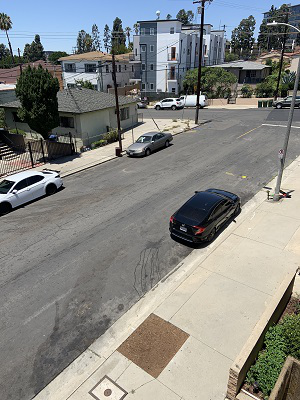

In [3]:
def standardize_img(imgArr):
    imgArr_norm = imgArr / 255 #put data between 0 and 1
    mean = np.mean(imgArr_norm, axis=0)
    std = np.std(imgArr_norm, axis=0)
    standardized = (imgArr_norm - mean) / std #0 mean and 1 std
    rescaled_1 = (standardized - np.min(standardized, axis=0)) 
    rescaled_2 = (np.max(standardized, axis=0) - np.min(standardized, axis=0))
    rescaled = rescaled_1/rescaled_2 #make the standardized data fall between 0 and 1 again
    return rescaled

# Read all images from specified path. Return the image object, the image as a flattened array, and the original image shape
def img_contents(img_list, img_idx='random', dirPath="data\\original_images", standardize=True):
    if img_idx=='random':
        img_idx = np.random.randint(0, len(img_list))
    img = Image.open(f'{dirPath}\\{img_list[img_idx]}')
    imgArr = np.asarray(img)
    img_shape = imgArr.shape
    imgArr = imgArr.reshape(img_shape[0]*img_shape[1], img_shape[2])
    if standardize:
        imgArr = standardize_img(imgArr)
    return (img, imgArr, img_shape)

# Use the above function to look at the contents from a random image file
samp_img_contents = img_contents(img_names[1:], 0)

samp_img = samp_img_contents[0]
samp_imgArr = samp_img_contents[1]
samp_imgShape = samp_img_contents[2]

display(md(f'Image shape: {samp_imgShape}'))
display(md(f'Image array shape: {samp_imgArr.shape}'))
samp_img

### Assert All Images Are Same Size. Omit Wrong Sizes

In [4]:
def adj_image_list(img_list, img_shape, dirPath="data\\original_images"):
    new_img_list = []
    for i, img in enumerate(img_list):
        sel_img = Image.open(f'{dirPath}\\{img}')
        true_shape = np.asarray(sel_img).shape
        if true_shape != img_shape:
            print(f'Image {img} is of shape {true_shape} instead of {img_shape} so it will not be included')
        else:
            new_img_list.append(img)
    return new_img_list
img_names = adj_image_list(img_names, (400,300,3))

Image IMG-01.jpg is of shape (399, 300, 3) instead of (400, 300, 3) so it will not be included


### Compress the Image with KMeans and View the Compression

<Figure size 432x288 with 0 Axes>

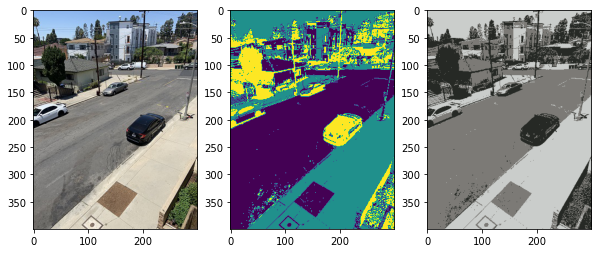

In [23]:
# Reduce image to k colors. Return the cluster centers and cluster labels for each pixel
def compress_image(imgArr, cluster_num):
    kmeans = KMeans(n_clusters=cluster_num, random_state=0)
    img_k2 = kmeans.fit(imgArr)
    
    labels = img_k2.labels_
    centers = img_k2.cluster_centers_
    return {'centers':centers, 'labels':labels} #want to make centers be between 0 and 255 again, and also want to normalize

# View the KMeans compressed images
def view_img_compression(img_dict, original=None, img_shape=(400,300)):
    if original is None:
        plt.figure()
        f, axarr = plt.subplots(1,2, figsize=(10,10))
        img_labels = img_dict['labels'].reshape(samp_imgShape[0], samp_imgShape[1])
        img_centers = img_dict['centers'][img_dict['labels']].reshape(samp_imgShape)
        axarr[0].imshow(img_labels)
        axarr[1].imshow(img_centers)
        plt.savefig("data\\exports\\kmeans_compression_ex.png")
        plt.show()
    else:
        plt.figure()
        f, axarr = plt.subplots(1,3, figsize=(10,10))
        img_labels = img_dict['labels'].reshape(samp_imgShape[0], samp_imgShape[1])
        img_centers = img_dict['centers'][img_dict['labels']].reshape(samp_imgShape)
        axarr[0].imshow(original)
        axarr[1].imshow(img_labels)
        axarr[2].imshow(img_centers) #img_centers
        plt.savefig("data\\exports\\kmeans_compression_ex.png")
        plt.show()
        
samp_comp = compress_image(samp_imgArr, 3)
view_img_compression(samp_comp, samp_img)

### Make a JSON file that has compressed image arrays, centers, and image shapes

In [78]:
clus_nums = [2,3,4,8,16]
def images2dict(clusterNumbersArr, img_names):
    txt_file = {}
    for clus_num in clusterNumbersArr:
        for i, img in enumerate(img_names):
            contents = img_contents(img_names, img_idx=i)
            imgArr = contents[1] 
            imgShape = contents[2]

            img_dict = compress_image(imgArr, clus_num)
            img_dict['centers'] = img_dict['centers'].tolist()
            img_dict['labels'] = img_dict['labels'].tolist()
            img_dict['shape'] = imgShape
            
            txt_file[f'cluster{clus_num}_img{i}'] = img_dict
            print(f'k={clus_num} clusters, IMG #{i}: COMPLETED', end='\r')

    print('\nFINISHED')
    return txt_file

def dict2json(myDict):
    my_json = json.dumps(myDict)
    f = open("data\\compressed_images.json", "w")
    f.write(my_json)
    f.close()

img_dict = images2dict(clus_nums, img_names)
dict2json(img_dict)

k=16 clusters, IMG #16: COMPLETED
FINISHED


### Read images from JSON file, choose compression type, and get image components of compression type

In [7]:
img_dict = json.load(open('data\\compressed_images.json'))

def compressed_img_components(img_dict, k, include_all=False):
    center_list = [] #all the cluster centers for each image
    label_list = []  #all the pixel labels for each image
    shape_list = []  #the shape of each image
    comp_list = []   #the RGB of each pixel label for each image
    for key, value in img_dict.items():
        if re.match(f'cluster{k}', key) or (re.match('cluster', key) and include_all):
            label_list.append(value['labels'])
            center_list.append(value['centers'])
            shape_list.append(value['shape'])
            
            comp_center = np.asarray(value['centers'])
            comp_label = np.asarray(value['labels'])
            comp_cmb = comp_center[comp_label]
            comp_list.append(comp_cmb.flatten())
    if len(shape_list) == 0: 
        print('images have not been compressed to that number of colors.')
    return (np.asarray(comp_list), np.asarray(label_list), np.asarray(center_list), shape_list)

### Run ISOMAP or PCA on Compressed Images

In [24]:
# return the images reduced to n dimensions by ISOMAP
def iso_points(imgsArr, n_components=2, n_neighbors=5):
    iso = Isomap(n_components=n_components, n_neighbors=n_neighbors)
    return iso.fit_transform(imgsArr)

# return the images reduced to n dimensions by PCA
def pca_points(imgsArr, n_components=2):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(imgsArr)

# plot images across reduced 2 components
def plot_isomap(iso_points, imgsArr, shapesArr, scale=.1):
    fig = plt.figure(dpi=200)
    fig.set_size_inches(10,10)
    ax = fig.add_subplot(111)
    ax.set_title('ISOMAP or PCA')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    
    for i in range(iso_points.shape[0]):
        img = imgsArr[i].reshape(shapesArr[i])
        x0 = iso_points[i,0] - (shapesArr[i][1] / 2) * scale
        x1 = iso_points[i,0] + (shapesArr[i][1] / 2) * scale
        y0 = iso_points[i,1] - (shapesArr[i][0] / 2) * scale
        y1 = iso_points[i,1] + (shapesArr[i][0] / 2) * scale
        ax.imshow(img, zorder=1, extent=(x0, x1, y0, y1), alpha=1)
    ax.scatter(iso_points[:,0], iso_points[:,1], c='r', zorder=2, s=15, marker='x')
    plt.savefig("data\\exports\\ISOMAP_PCA.png")

# use this function to play with inclusion of different ISOMAP and PCA components
def component_selection(iso_comps, pca_comps, iso_nb=5):
    if len(iso_comps)!=0 and len(pca_comps)!=0:
        iso_pts = iso_points(comp, n_components=np.max(np.array(iso_comps)), n_neighbors=iso_nb)[:,[i-1 for i in iso_comps]]
        pca_pts = pca_points(comp, n_components=np.max(np.array(pca_comps)))[:,[i-1 for i in pca_comps]]
        pts = np.concatenate((iso_pts, pca_pts), axis=1)
        return pts.reshape(comp.shape[0], iso_pts.shape[1]+pca_pts.shape[1])
    elif len(iso_comps)!=0 and len(pca_comps)==0:
        iso_pts = iso_points(comp, n_components=np.max(np.array(iso_comps)), n_neighbors=iso_nb)[:,[i-1 for i in iso_comps]]
        return iso_pts
    else:
        pca_pts = pca_points(comp, n_components=np.max(np.array(pca_comps)))[:,[i-1 for i in pca_comps]]
        return pca_pts

### Choose KMeans compression size and get components of images

In [15]:
k=8
comp, labels, centers, shapes = compressed_img_components(img_dict, k, include_all=False) 

### Play with 2 components from ISOMAP or PCA

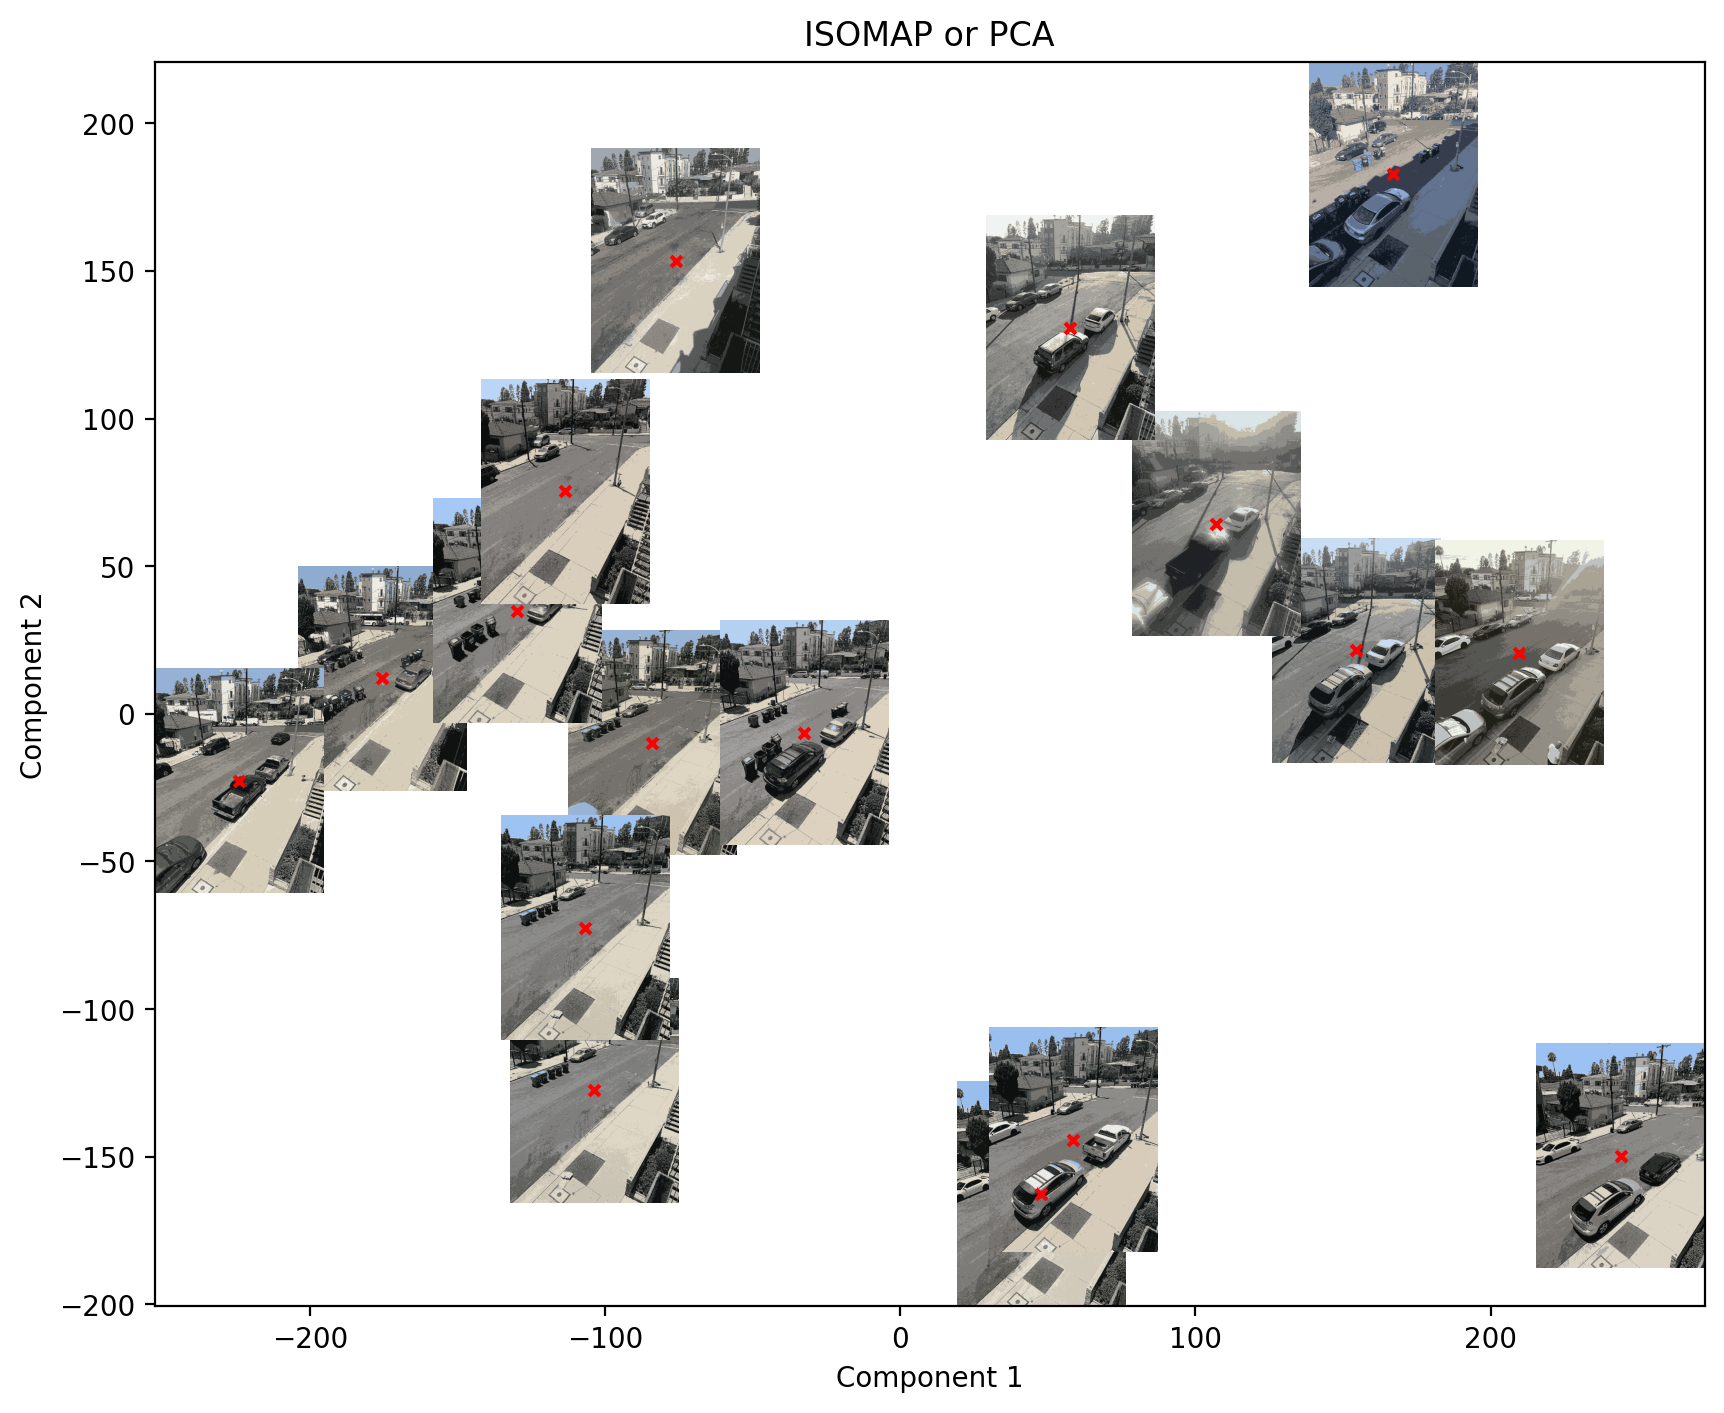

In [28]:
pts = component_selection(iso_comps = [1,2], pca_comps = [], iso_nb=5) #ex. iso_comps = [1], pca_comps = [3]
assert pts.shape[1]<=2, 'For plotting use only 2 dimensions!'
plot_isomap(pts, comp, shapes, scale=.19) #change scale to adjust image sizes

### Run GMM with $n$ components and sort images by probability of available parking

In [31]:
def run_gmm(X, standardize=True, n_components=2):
    if standardize:
        X = StandardScaler().fit_transform(X)
    
    gmm = GMM(n_components=n_components, random_state=0)
    gmm = gmm.fit(X)
    proba = gmm.predict_proba(X)
    pred = gmm.predict(X)
    
    return (X, proba, pred)

def display_gmm(proba, pred, imgsArr, shapes, sort_col, save_fig=False):
    img_num = pred.shape[0]
    order = proba[:, sort_col].argsort()[::-1]
    
    proba_sort = proba[order]
    pred_sort = pred[order]
    comp_sort = imgsArr[order]
    shapes_sort = np.asarray(shapes)[order]
    
    plt.ion()
    for i in range(img_num):
        print(f'\n----- IMAGE {i+1} -----')
        print(f'Probability: {round(proba_sort[i,0],5)*100}%')
        print(f'Classification: {pred_sort[i]}')
        plt.imshow(comp_sort[i].reshape(tuple(shapes_sort[i])))
        if save_fig:
            plt.savefig(f"data\\exports\\gmm_rank\\available{i+1}.png")
        plt.draw()
        plt.pause(0.1)

Shape of points is (17, 4)


----- IMAGE 1 -----
Probability: 100.0%
Classification: 0


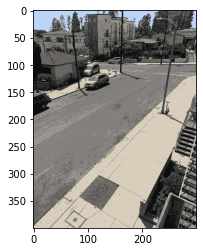


----- IMAGE 2 -----
Probability: 100.0%
Classification: 0


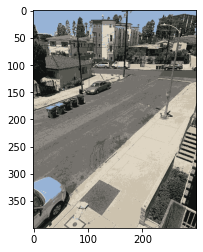


----- IMAGE 3 -----
Probability: 100.0%
Classification: 0


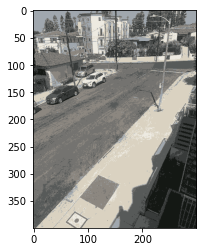


----- IMAGE 4 -----
Probability: 100.0%
Classification: 0


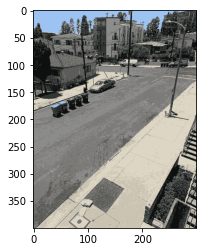


----- IMAGE 5 -----
Probability: 99.998%
Classification: 0


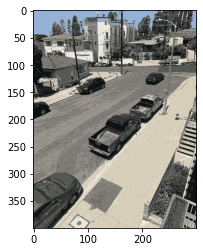


----- IMAGE 6 -----
Probability: 99.992%
Classification: 0


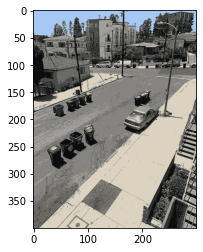


----- IMAGE 7 -----
Probability: 99.944%
Classification: 0


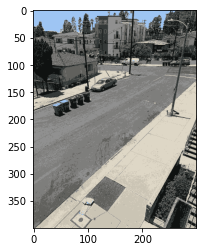


----- IMAGE 8 -----
Probability: 99.844%
Classification: 0


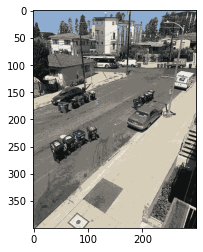


----- IMAGE 9 -----
Probability: 0.0%
Classification: 1


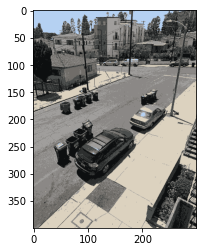


----- IMAGE 10 -----
Probability: 0.0%
Classification: 1



----- IMAGE 11 -----
Probability: 0.0%
Classification: 1


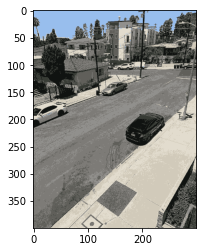


----- IMAGE 12 -----
Probability: 0.0%
Classification: 1


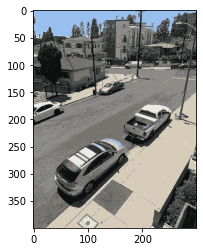


----- IMAGE 13 -----
Probability: 0.0%
Classification: 1


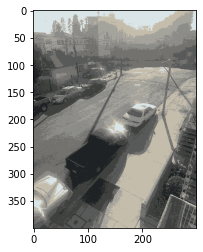


----- IMAGE 14 -----
Probability: 0.0%
Classification: 1


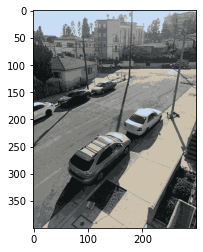


----- IMAGE 15 -----
Probability: 0.0%
Classification: 1


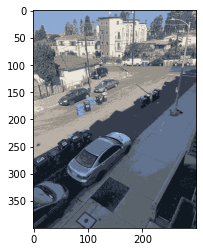


----- IMAGE 16 -----
Probability: 0.0%
Classification: 1



----- IMAGE 17 -----
Probability: 0.0%
Classification: 1


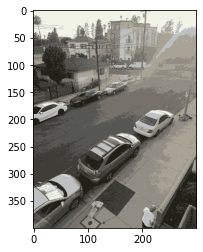

In [32]:
# Play with the number of GMM clusters, which ISOMAP components are used, and which PCA components are used

pts = component_selection(iso_comps=[1,2,3], pca_comps=[1])
display(md(f'Shape of points is {pts.shape}'))

gmm = run_gmm(pts, n_components=2)
gmm_proba = gmm[1]
gmm_pred = gmm[2]

display_gmm(gmm_proba, gmm_pred, comp, shapes, sort_col=0, save_fig=True)

Shape of points is (17, 4)


----- IMAGE 1 -----
Probability: 100.0%
Classification: 0


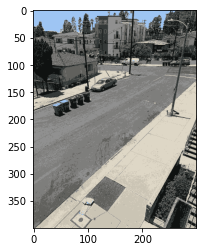


----- IMAGE 2 -----
Probability: 100.0%
Classification: 0


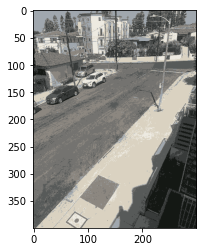


----- IMAGE 3 -----
Probability: 100.0%
Classification: 0


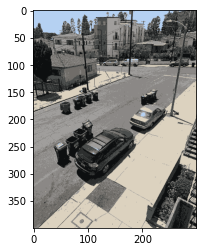


----- IMAGE 4 -----
Probability: 100.0%
Classification: 0


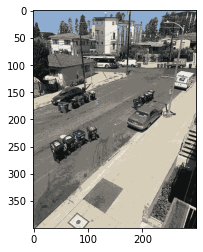


----- IMAGE 5 -----
Probability: 100.0%
Classification: 0


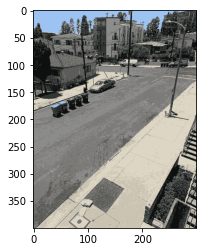


----- IMAGE 6 -----
Probability: 100.0%
Classification: 0


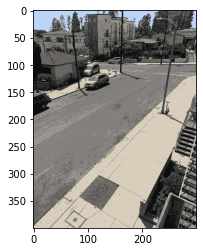


----- IMAGE 7 -----
Probability: 100.0%
Classification: 0


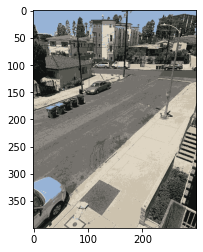


----- IMAGE 8 -----
Probability: 100.0%
Classification: 0


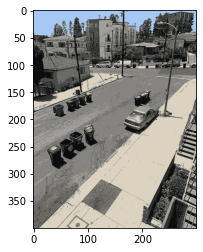


----- IMAGE 9 -----
Probability: 100.0%
Classification: 0


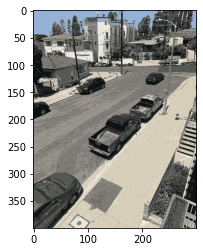


----- IMAGE 10 -----
Probability: 0.0%
Classification: 1


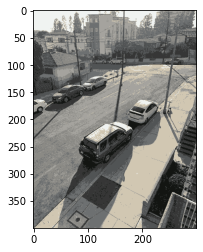


----- IMAGE 11 -----
Probability: 0.0%
Classification: 1


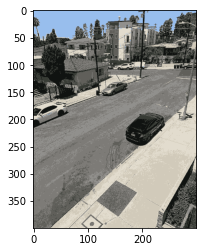


----- IMAGE 12 -----
Probability: 0.0%
Classification: 1


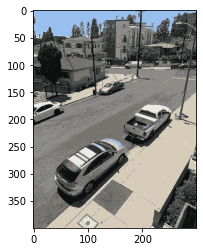


----- IMAGE 13 -----
Probability: 0.0%
Classification: 1


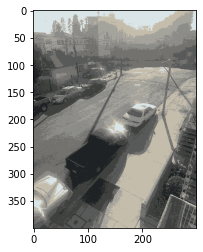


----- IMAGE 14 -----
Probability: 0.0%
Classification: 1


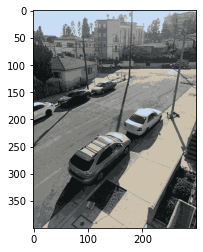


----- IMAGE 15 -----
Probability: 0.0%
Classification: 1


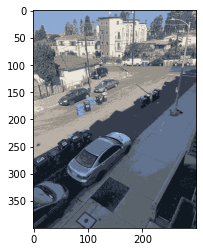


----- IMAGE 16 -----
Probability: 0.0%
Classification: 1



----- IMAGE 17 -----
Probability: 0.0%
Classification: 1


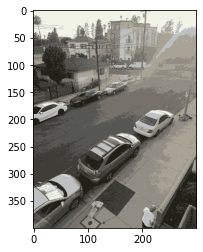

In [22]:
# Play with the number of GMM clusters, which ISOMAP components are used, and which PCA components are used

pts = component_selection(iso_comps=[1,2,3], pca_comps=[1], iso_nb=3)
display(md(f'Shape of points is {pts.shape}'))

gmm = run_gmm(pts, n_components=2)
gmm_proba = gmm[1]
gmm_pred = gmm[2]

display_gmm(gmm_proba, gmm_pred, comp, shapes, sort_col=0)

The best outcome I have found so far is to run GMM with $2$ clusters, while using the first $3$ components of ISOMAP \
and first component of PCA as input features.